In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_csv(r'/content/Loan_default.csv', index_col=0)

In [3]:
print(df.isna().sum())

Age               0
Income            0
LoanAmount        0
CreditScore       0
MonthsEmployed    0
NumCreditLines    0
InterestRate      0
LoanTerm          0
DTIRatio          0
Education         0
EmploymentType    0
MaritalStatus     0
HasMortgage       0
HasDependents     0
LoanPurpose       0
HasCoSigner       0
Default           0
dtype: int64


In [4]:
#no empty values detected

In [5]:
#Encoding values

In [6]:
label_encoder = LabelEncoder()

In [7]:
columns_to_encode = ['Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner', 'Default']
df[columns_to_encode] = df[columns_to_encode].apply(lambda col: label_encoder.fit_transform(col))

In [8]:
#Train, validation, test split

In [9]:
train,valid,test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

In [10]:
from collections import Counter

In [11]:
count = Counter(train['Default'])
count

Counter({0: 135568, 1: 17640})

In [12]:
# Since the classes are imbalanced, there is a need to oversample

In [13]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

In [14]:
def scale_dataset(df, oversampler=False):
    x = df[df.columns[:-1]].values
    y = df[df.columns[-1]].values
    scaler = StandardScaler()
    x = scaler.fit_transform(x)
    if oversampler:
        ros = RandomOverSampler()
        x,y = ros.fit_resample(x,y)
    data = np.hstack((x, np.reshape(y, (-1,1))))
    return data, x, y

In [15]:
train, x_train, y_train = scale_dataset(df, True)
valid, x_valid, y_valid = scale_dataset(df, False)
test, x_test, y_test = scale_dataset(df, False)

In [16]:
count = Counter(y_train)
count

Counter({0: 225694, 1: 225694})

In [17]:
# Now that both classes are equally distributed we can train our model

In [18]:
from sklearn.metrics import classification_report as cr
from sklearn.metrics import confusion_matrix as cm

In [19]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Binary crossentropy')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

In [21]:
import tensorflow as tf

In [25]:
nn_model = tf.keras.Sequential(
  [
  tf.keras.layers.Dense(740, activation='tanh', input_shape=x_train[0].shape),
  tf.keras.layers.Dense(280, activation='tanh'),
  tf.keras.layers.Dense(10, activation='tanh'),
  tf.keras.layers.Dense(1, activation='sigmoid'),
  ]
)
nn_model.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [24]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [26]:
history = nn_model.fit(x_train, y_train, epochs=100, validation_data=(x_valid, y_valid), callbacks=[stop_early])

Epoch 1/100
14106/14106 [==============================] - 77s 5ms/step - loss: 0.5950 - accuracy: 0.6812 - val_loss: 0.5879 - val_accuracy: 0.6780
Epoch 2/100
14106/14106 [==============================] - 72s 5ms/step - loss: 0.5890 - accuracy: 0.6861 - val_loss: 0.6019 - val_accuracy: 0.6673
Epoch 3/100
14106/14106 [==============================] - 68s 5ms/step - loss: 0.5865 - accuracy: 0.6883 - val_loss: 0.5716 - val_accuracy: 0.6985
Epoch 4/100
14106/14106 [==============================] - 67s 5ms/step - loss: 0.5838 - accuracy: 0.6901 - val_loss: 0.5738 - val_accuracy: 0.6973
Epoch 5/100
14106/14106 [==============================] - 73s 5ms/step - loss: 0.5806 - accuracy: 0.6923 - val_loss: 0.5703 - val_accuracy: 0.7109
Epoch 6/100
14106/14106 [==============================] - 66s 5ms/step - loss: 0.5764 - accuracy: 0.6959 - val_loss: 0.5793 - val_accuracy: 0.6967
Epoch 7/100
14106/14106 [==============================] - 66s 5ms/step - loss: 0.5715 - accuracy: 0.7001 - val_

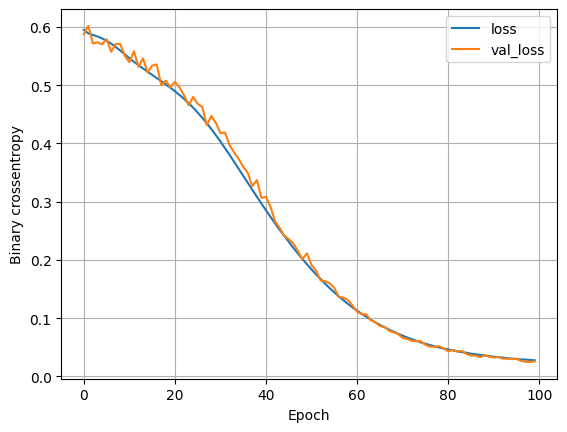

In [27]:
plot_loss(history)

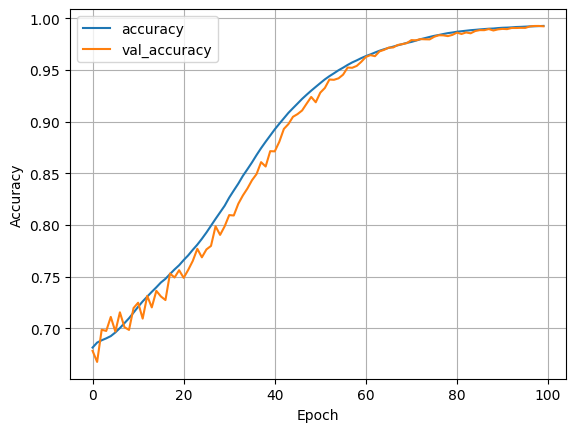

In [28]:
plot_accuracy(history)

In [29]:
y_predict = nn_model.predict(x_test)

7980/7980 [==============================] - 13s 2ms/step


In [35]:
y_pred_binary = (y_predict >= 0.5).astype(int)

In [36]:
cr_nn = cr(y_test, y_pred_binary)

In [37]:
print(cr_nn)

              precision    recall  f1-score   support

           0       1.00      0.99      1.00    225694
           1       0.94      0.99      0.97     29653

    accuracy                           0.99    255347
   macro avg       0.97      0.99      0.98    255347
weighted avg       0.99      0.99      0.99    255347

